In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
train_file = "./input/train.csv"
test_file = "./input/test.csv"
output_file = "./output/submission.csv"

In [3]:
raw_data = np.loadtxt(train_file, skiprows=1, dtype='int', delimiter=',')
x_train, x_dev, y_train, y_dev = train_test_split(raw_data[:,1:], raw_data[:,0], test_size=0.1,random_state=0)

Text(0.5,1,'28x28 data')

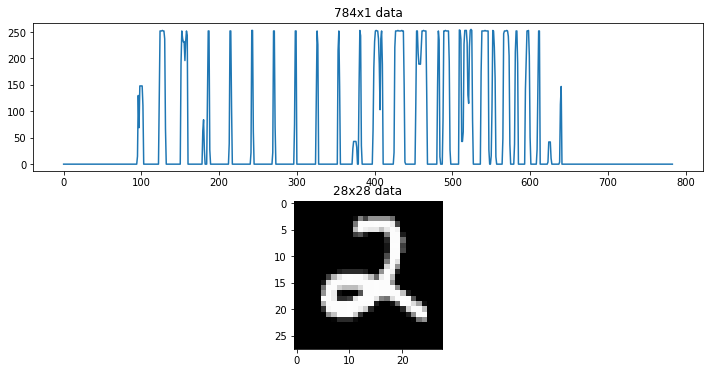

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(12,6))
ax[0].plot(x_train[0])
ax[0].set_title('784x1 data')
ax[1].imshow(x_train[0].reshape(28,28),cmap='gray')
ax[1].set_title('28x28 data')

In [5]:
x_train = x_train.reshape(-1,28,28,1)
x_dev = x_dev.reshape(-1,28,28,1)

In [6]:
x_train = x_train.astype("float32")/255.0
x_dev = x_dev.astype("float32")/255.0

In [7]:
y_train = to_categorical(y_train)
y_dev = to_categorical(y_dev)

In [8]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (5, 5),padding='same', activation='relu',input_shape = (28, 28, 1)))
model.add(BatchNormalization())
model.add(Conv2D(filters = 32, kernel_size = (5, 5),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPool2D((2, 2), strides=(2, 2)))

model.add(Conv2D(filters = 64, kernel_size = (3, 3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = 64, kernel_size = (3, 3),padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(MaxPool2D((2, 2), strides=(2, 2)))

model.add(Flatten())
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

In [9]:
augmented_data_generator = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

augmented_data_genterator = ImageDataGenerator(zoom_range = 0.1,
                            height_shift_range = 0.1,
                            width_shift_range = 0.1,
                            rotation_range = 10)

In [10]:
model.compile(loss='categorical_crossentropy', optimizer = Adam(lr=1e-4), metrics=["accuracy"])

In [11]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

In [12]:
hist = model.fit_generator(augmented_data_gentenator.flow(x_train, y_train, batch_size=64),
                           steps_per_epoch=1024,
                           epochs=30,
                           verbose=1,  # 0 = silent, 1 = progress bar, 2 = one line per epoch.
                           #validation_data=(x_val[:400,:], y_val[:400,:]), #For speed
                           validation_data=(x_dev, y_dev),
                           callbacks=[annealer])

Epoch 1/30
1024/1024 [==============================] - 18s 18ms/step - loss: 0.3136 - acc: 0.9077 - val_loss: 0.0668 - val_acc: 0.9829
Epoch 2/30
1024/1024 [==============================] - 17s 16ms/step - loss: 0.0899 - acc: 0.9769 - val_loss: 0.1383 - val_acc: 0.9729
Epoch 3/30
1024/1024 [==============================] - 17s 16ms/step - loss: 0.0740 - acc: 0.9811 - val_loss: 0.0495 - val_acc: 0.9864
Epoch 4/30
1024/1024 [==============================] - 17s 16ms/step - loss: 0.0610 - acc: 0.9845 - val_loss: 0.0322 - val_acc: 0.9931
Epoch 5/30
1024/1024 [==============================] - 17s 16ms/step - loss: 0.0506 - acc: 0.9873 - val_loss: 0.0387 - val_acc: 0.9902
Epoch 6/30
1024/1024 [==============================] - 17s 16ms/step - loss: 0.0431 - acc: 0.9888 - val_loss: 0.0443 - val_acc: 0.9888
Epoch 7/30
1024/1024 [==============================] - 17s 16ms/step - loss: 0.0397 - acc: 0.9900 - val_loss: 0.0428 - val_acc: 0.9902
Epoch 8/30
1024/1024 [==========================

In [13]:
final_loss, final_acc = model.evaluate(x_dev, y_dev, verbose=0)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

Final loss: 0.0295, final accuracy: 0.9945


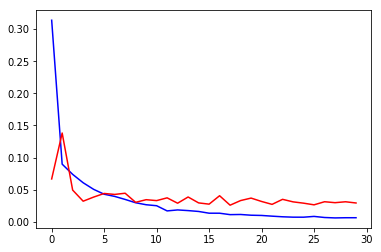

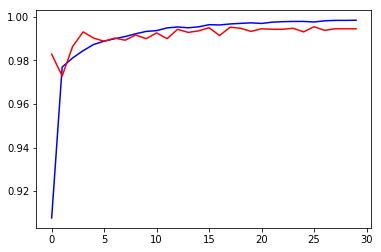

In [14]:
plt.plot(hist.history['loss'], color='b')
plt.plot(hist.history['val_loss'], color='r')
plt.show()
plt.plot(hist.history['acc'], color='b')
plt.plot(hist.history['val_acc'], color='r')
plt.show()

In [15]:
y_hat = model.predict(x_dev)
y_pred = np.argmax(y_hat, axis=1)
y_true = np.argmax(y_dev, axis=1)
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[422   0   0   0   0   0   0   0   0   0]
 [  0 473   0   0   0   0   0   0   0   0]
 [  1   0 406   0   0   0   0   2   0   0]
 [  0   0   0 421   0   3   0   1   1   0]
 [  0   1   0   0 423   0   1   0   0   4]
 [  0   0   0   0   0 381   1   0   0   0]
 [  0   0   0   0   1   0 411   0   0   0]
 [  0   1   0   0   0   0   0 468   0   0]
 [  2   0   0   0   0   1   1   1 379   0]
 [  0   0   0   0   1   0   0   0   0 393]]


In [16]:
mnist_testset = np.loadtxt(test_file, skiprows=1, dtype='int', delimiter=',')
x_test = mnist_testset.astype("float32")
x_test = x_test.reshape(-1, 28, 28, 1)/255.

In [17]:
y_hat = model.predict(x_test, batch_size=64)

In [18]:
y_pred = np.argmax(y_hat,axis=1)

In [19]:
with open(output_file, 'w') as f :
    f.write('ImageId,Label\n')
    for i in range(len(y_pred)) :
        f.write("".join([str(i+1),',',str(y_pred[i]),'\n']))